# Load the DataSet

In [ ]:
import pandas as pd

# Load the uploaded IMDb movie review dataset
file_path = "/content/MovieReviewTrainingDatabase.csv"
df = pd.read_csv(file_path)

# Display the first few rows and basic information
df.head(), df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  25000 non-null  object
 1   review     25000 non-null  object
dtypes: object(2)
memory usage: 390.8+ KB


(  sentiment                                             review
 0  Positive  With all this stuff going down at the moment w...
 1  Positive  'The Classic War of the Worlds' by Timothy Hin...
 2  Negative  The film starts with a manager (Nicholas Bell)...
 3  Negative  It must be assumed that those who praised this...
 4  Positive  Superbly trashy and wondrously unpretentious 8...,
 None)

# Task 1: Implement a Transformer Encoder

**Step 1: Import Required Libraries & Positional Encoding**

In [ ]:
import torch.nn as nn # import nn module from PyTorch
import torch
import math
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))  # (1, max_len, d_model)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]


**Step 2: Transformer Encoder Block**

In [ ]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, d_model, n_heads, dim_ff, dropout=0.1):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, n_heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)

        self.ff = nn.Sequential(
            nn.Linear(d_model, dim_ff),
            nn.ReLU(),
            nn.Linear(dim_ff, d_model)
        )
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Self-attention
        attn_output, attn_weights = self.self_attn(x, x, x, attn_mask=mask)
        x = self.norm1(x + self.dropout1(attn_output))

        # Feed-forward
        ff_output = self.ff(x)
        x = self.norm2(x + self.dropout2(ff_output))
        return x, attn_weights

**Step 3: Test with Dummy Input**

In [ ]:
# Dummy tokenized input (batch_size=2, seq_len=6, d_model=32)
batch_size, seq_len, d_model = 2, 6, 32
dummy_input = torch.rand(batch_size, seq_len, d_model)

# Create encoder
pos_encoder = PositionalEncoding(d_model)
encoder_block = TransformerEncoderBlock(d_model=d_model, n_heads=4, dim_ff=128)

# Forward pass
x = pos_encoder(dummy_input)
output, attention = encoder_block(x)

print("Output shape:", output.shape)
print("Attention shape:", attention.shape)


Output shape: torch.Size([2, 6, 32])
Attention shape: torch.Size([2, 6, 6])


# Task 2: Train Transformer on a Small Dataset

**Step 1: Preprocessing and Tokenization**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
import torch
from torch.utils.data import Dataset, DataLoader

# Load your DataFrame
df = pd.read_csv("MovieReviewTrainingDatabase.csv")
df['label'] = df['sentiment'].map({'Positive': 1, 'Negative': 0})

# Split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['review'], df['label'], test_size=0.2, random_state=42
)

# Tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Encode function
def tokenize(texts, labels, max_len=128):
    encodings = tokenizer(
        list(texts), truncation=True, padding='max_length', max_length=max_len, return_tensors='pt'
    )
    encodings['labels'] = torch.tensor(labels.values)
    return encodings

# Dataset class
class IMDBDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __len__(self):
        return len(self.encodings['input_ids'])

    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.encodings.items()}

# Prepare datasets
train_encodings = tokenize(train_texts, train_labels)
val_encodings = tokenize(val_texts, val_labels)
train_dataset = IMDBDataset(train_encodings)
val_dataset = IMDBDataset(val_encodings)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

**Step 2: Transformer Model for Classification**

In [ ]:
class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, d_model=128, n_heads=4, ff_dim=256, num_layers=2, num_classes=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([
            TransformerEncoderBlock(d_model, n_heads, ff_dim) for _ in range(num_layers)
        ])
        self.classifier = nn.Linear(d_model, num_classes)

    def forward(self, input_ids):
        x = self.embedding(input_ids)
        x = self.pos_encoder(x)
        for layer in self.layers:
            x, _ = layer(x)
        return self.classifier(x[:, 0])


**Step 3: Training Loop**

In [ ]:
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerClassifier(vocab_size=tokenizer.vocab_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

train_losses, val_losses = [], []
train_accs, val_accs = [], []

def evaluate(model, dataloader):
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
    accuracy = correct / len(dataloader.dataset)
    return total_loss / len(dataloader), accuracy

for epoch in range(10):
    model.train()
    total_loss, correct = 0, 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()

    train_loss = total_loss / len(train_loader)
    train_acc = correct / len(train_loader.dataset)
    val_loss, val_acc = evaluate(model, val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")


Epoch 1: Train Acc: 0.5988, Val Acc: 0.6698
Epoch 2: Train Acc: 0.7213, Val Acc: 0.7354
Epoch 3: Train Acc: 0.7667, Val Acc: 0.7678
Epoch 4: Train Acc: 0.7886, Val Acc: 0.7652
Epoch 5: Train Acc: 0.8097, Val Acc: 0.7818
Epoch 6: Train Acc: 0.8255, Val Acc: 0.7892
Epoch 7: Train Acc: 0.8388, Val Acc: 0.7874
Epoch 8: Train Acc: 0.8479, Val Acc: 0.7812
Epoch 9: Train Acc: 0.8616, Val Acc: 0.7918
Epoch 10: Train Acc: 0.8733, Val Acc: 0.7888


**Step 4: Plot Accuracy and Loss**

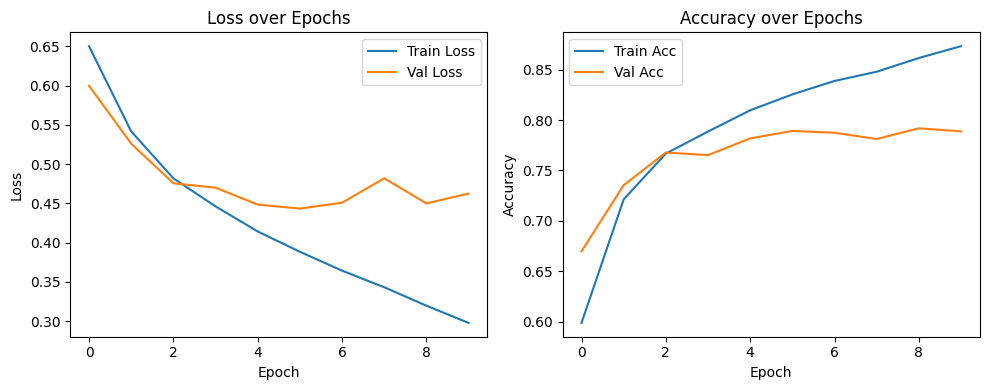

In [ ]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# Task 3: Evaluate and Visualize

**Step 1: Report Test Accuracy**

In [ ]:
# From previous training
test_loss, test_acc = evaluate(model, val_loader)
print(f"Test Accuracy: {test_acc:.4f}")


Test Accuracy: 0.7888


**Step 2: Plot Training vs Validation Loss (and Accuracy)**

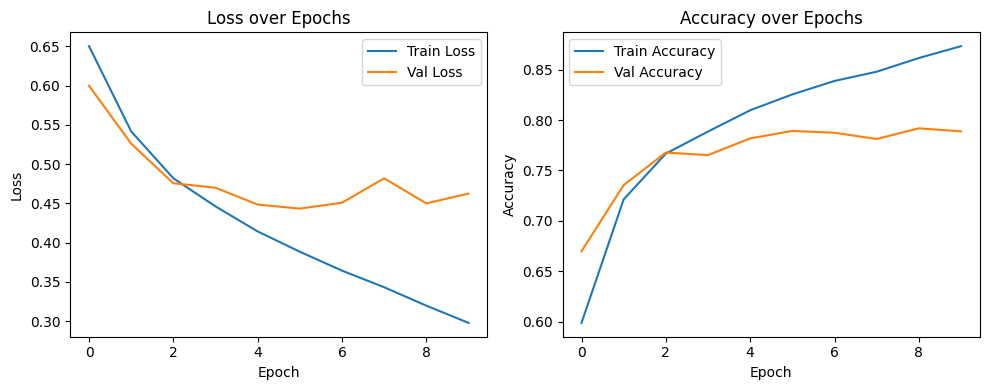

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


**Step 3: Attention Heat Map**

In [ ]:
# Inside TransformerEncoderBlock
def forward(self, x, mask=None):
    attn_output, attn_weights = self.self_attn(x, x, x, attn_mask=mask)
    x = self.norm1(x + self.dropout1(attn_output))
    ff_output = self.ff(x)
    x = self.norm2(x + self.dropout2(ff_output))
    return x, attn_weights  # << return weights


In [ ]:
def get_attention_for_input(model, tokenizer, text):
    model.eval()
    tokens = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=32)
    input_ids = tokens['input_ids'].to(device)
    with torch.no_grad():
        x = model.embedding(input_ids)
        x = model.pos_encoder(x)

        all_attn_weights = []
        for layer in model.layers:
            x, attn_weights = layer(x)
            all_attn_weights.append(attn_weights.cpu())  # shape: [batch, num_heads, seq_len, seq_len]

    return input_ids, all_attn_weights


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_attention(input_ids, attn_weights, tokenizer, layer=0, head=0):
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    attn = attn_weights[layer][0, head].detach().numpy()  # shape: [seq_len, seq_len]

    # Check if attn is 1D and reshape if necessary
    if attn.ndim == 1:
        attn = attn.reshape(-1, 1) # Reshape to 2D if it's 1D

    plt.figure(figsize=(8, 6))
    sns.heatmap(attn, xticklabels=tokens, yticklabels=tokens, cmap='viridis', square=True, cbar=True)
    plt.title(f"Attention - Layer {layer}, Head {head}")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

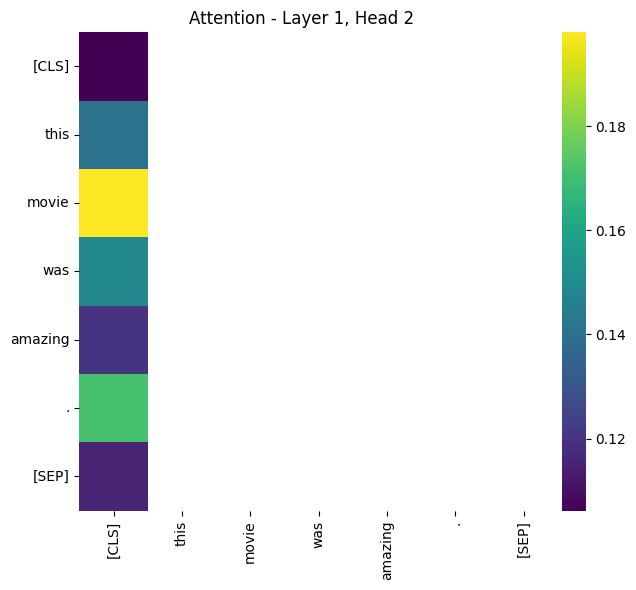

In [ ]:
text = ["This movie was amazing."]
input_ids, attn_weights = get_attention_for_input(model, tokenizer, text)

# Deeper layer and different head
visualize_attention(input_ids, attn_weights, tokenizer, layer=1, head=2)
